In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cobra
import snek
import h5py
import os

In [2]:
slim_core = cobra.io.read_sbml_model("../00_files/slim_core.xml")

In [3]:
def parse_summary_file(dirname):
    # get summary
    with open("../01_simulations/"+dirname+"/summary.txt","r") as file:
        lines = file.readlines()

    timing = False
    sum_dic = {}
    for i, line in enumerate(lines):
        if (i)%3 == 0:
            pass
        elif (i-2)%3 == 0:
            if line[0].isnumeric() or line[0] == "-":
                tmp_item = [float(line)]
            else:
                tmp_str = line.strip("\n")
                if tmp_str[0] == "[":
                    tmp_item = [[float(i) for i in tmp_str.strip("[").strip("]").split(",")]]
                else:
                    tmp_item = [tmp_str]
                pass
            if timing:
                sum_dic[tmp_key+" in s"] = tmp_item
                sum_dic[tmp_key+" in min"] = [i/60 for i in tmp_item]
            else:
                sum_dic[tmp_key.replace("pDNA","product")] = tmp_item
        else:
            tmp_key = line.strip("#----").strip("\n")
            if "Time E" in tmp_key:
                timing = True
            else:
                timing = False
    sum_df = pd.DataFrame(sum_dic).T
    sum_df.columns = [dirname]
    return sum_dic, sum_df

# Process Comparison

Process                        | P       | P/t     | P/V     | P/Gfed  | Opt Time
                               | g       | g/h     | g/L     | mol/mol | min    
---------------------------------------------------------------------------------
$\mathcal{T}\,$v2023/v2024     |   7.335 |   0.445 |   7.651 |   0.001 |   3.612
$\mathcal{P}\,$v2024           |   4.554 |   0.421 |   4.750 |   0.001 |   6.621
$\mathcal{P}\,$v2023           |   4.226 |   0.391 |   4.408 |   0.001 |  12.929


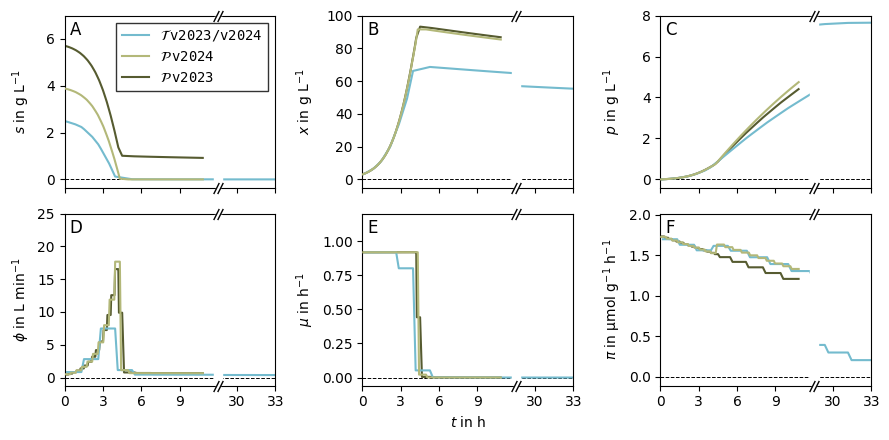

In [4]:
dirnames = ["T_v2024","P_v2024","P_v2023"]
labels = [r"$\mathcal{T}\,$v2023/v2024",r"$\mathcal{P}\,$v2024",r"$\mathcal{P}\,$v2023"]
colors = ["#74bbce","#b3b879","#565b30"] # 
zorders = [2,3,1]

def axis_breaker(start,end,df,xticks):
    broken_df = df.copy()
    broken_df.loc[(df.t.values>start)&(df.t.values<end),"t"] = start #df.loc[(df.t.values>start)&(df.t.values<28.5),"t"].values-
    broken_df.loc[df.t.values>=end,"t"] = df.loc[df.t.values>=end,"t"].values-end+start

    broken_xticks = xticks.astype(float).copy()
    broken_xticks[(broken_xticks>start)&(broken_xticks<end)] = start
    delta = start-end
    broken_xticks[broken_xticks>=end] += delta
    return broken_df, broken_xticks

BREAKSTART = 12
BREAKEND   = 28.5
xticklabels = np.array([0,3,6,9,30,33])
fig = plt.figure(dpi=100,figsize=(9,4.5))
axes = []
for i in range(6):
    ax = fig.add_subplot(2,3,i+1)
    axes.append(ax)
    ax.axhline(0,color="k",linewidth=.7,linestyle="--")

print(f"{'Process':30} | {'P':7} | {'P/t':7} | {'P/V':7} | {'P/Gfed':7} | {'Opt Time':7}")
print(f"{' ':30} | {'g':7} | {'g/h':7} | {'g/L':7} | {'mol/mol':7} | {'min':7}")
print("---------------------------------------------------------------------------------")

# PLOT LINES
for nr, (dirname,label,zorder) in enumerate(zip(dirnames,labels,zorders)):
    df = pd.read_csv("../01_simulations/"+dirname+"/df.csv")
    df,xticks = axis_breaker(start=BREAKSTART,end=BREAKEND,df=df,xticks=xticklabels)
    sum_dic, sum_df = parse_summary_file(dirname)
    if len(dirnames) == len(colors):
        kwargs = {"color":colors[nr],"zorder":zorder}
    else:
        kwargs = {"zorder":zorder}
    axes[1].plot(df.t,df.X/df.V,**kwargs)
    axes[2].plot(df.t,df.P*slim_core.metabolites.pDNA_c.formula_weight/1000/df.V,**kwargs)
    axes[0].plot(df.t,df.S*slim_core.metabolites.so4_c.formula_weight/1000/df.V,**kwargs,label=label)
    axes[3].plot(df.t,df.r_V*60,**kwargs)
    axes[4].plot(df.t,df.q_X,**kwargs)
    axes[5].plot(df.t,df.q_P*1000,**kwargs)
    c_G = 450/.18015588
    tmp_P = df.P.values[-1]*slim_core.metabolites.pDNA_c.formula_weight/1000
    tmp_Pt = df.P.values[-1]/df.t.values[-1]*slim_core.metabolites.pDNA_c.formula_weight/1000
    tmp_PV = df.P.values[-1]/df.V.values[-1]*slim_core.metabolites.pDNA_c.formula_weight/1000
    tmp_PG = df.P.values[-1]/((df.V.values[-1]-0.5)*c_G)
    print(f"""{label:30} | {tmp_P:>7.3f} | {tmp_Pt:7.3f} | {tmp_PV:7.3f} | {tmp_PG:7.3f} | {sum_dic['Time Elapsed in min'][0]:7.3f}""")

# LABEL AXES, SET YLIM
if True:
    axes[1].set_ylabel(r"$x$ in g L$^{-1}$")
    axes[2].set_ylabel(r"$p$ in g L$^{-1}$")
    axes[0].set_ylabel(r"$s$ in g L$^{-1}$")
    axes[3].set_ylabel(r"$\phi$ in L min$^{-1}$")
    axes[4].set_ylabel(r"$\mu$ in h$^{-1}$")
    axes[5].set_ylabel(r"$\pi$ in µmol g$^{-1}$ h$^{-1}$")

    axes[3].set_ylim(-25/20,25)
    axes[4].set_ylim(-1.2/20,1.2)
    axes[5].set_ylim(-2/20,2)
    axes[0].set_ylim(-7/20,7)
    axes[1].set_ylim(-100/20,100)
    axes[2].set_ylim(-8/20,8)

    offset = .01
    axes[5].set_ylim(np.array(axes[5].get_ylim())+np.array([-offset,offset]))
    axes[4].set_xlabel(r"$t$ in h")

# BROKEN AXIS
if True:
    for ax in axes:
        ax.set_xlim(0,33-BREAKEND+BREAKSTART)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)

        d = .5  # proportion of vertical to horizontal extent of the slanted line
        kwargs = dict(marker=[(-d, -1), (d, 1)], markersize=8,
                      linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        f = BREAKSTART/(33-BREAKEND+BREAKSTART)
        os1 = .01
        ax.plot([f-os1, f-os1], [0, 1], transform=ax.transAxes, **kwargs,zorder=5)
        ax.plot([f+os1, f+os1], [0, 1], transform=ax.transAxes, **kwargs,zorder=5)
        kwargs = dict(marker="s", markersize=3,
                      linestyle="none", color='w', mec='w', mew=1, clip_on=False)
        ax.plot([f, f], [0, 1], transform=ax.transAxes, **kwargs,zorder=3)
        os2 = .01
        ax.fill_between([f-os1*2, f+os1*2], [1-os2, 1-os2], [0+os2,0+os2], color="w", transform=ax.transAxes,zorder=4)

    for ax in axes[:3]:
        ax.set_xticklabels([])

# SUBPLOTS
if True:
    import matplotlib.transforms as mtransforms
    for name, ax in zip(['A','B','C','D','E',"F","G","H","I","J"],axes):
        trans = mtransforms.ScaledTranslation(5/100, -5/100, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, name, transform=ax.transAxes + trans,
                fontsize='large', verticalalignment='top', fontfamily='sans',
                bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

axes[0].legend(loc="upper right",ncol=1,prop={'family': 'monospace'})
fig.align_ylabels()
plt.tight_layout()
plt.show()

# Finite Element Lengths

P_v2023
P_v2024


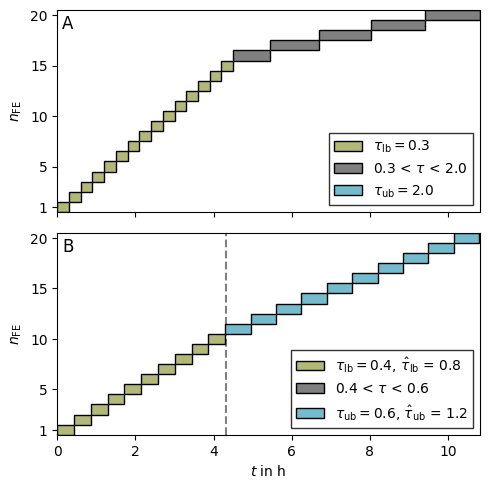

In [5]:
def get_nFE(dirname):
    with open("../01_simulations/"+dirname+".jl","r") as file:
        lines = file.readlines()
    sum_dic, sum_df = parse_summary_file(dirname)
    print(dirname)
    
    lb_rtFE,lb_tFE,ub_rtFE,ub_tFE = np.nan, np.nan, np.nan, np.nan
    # find the (r)tFE bounds
    old_implementation = 0
    new_implementation = 0
    # except if the bounds are no numbers, but fixed to variables
    unknown_bounds = False
    f = h5py.File("../01_simulations/"+dirname+"/variables.jld2", "r")
    timescale = np.array(f["t_end_"])
    for line in lines:
        if "tFE_max = " in line:
            ub_tFE = float(line.split("=")[1].strip("\n").strip(" ").strip("# h"))
            old_implementation += 1
        elif "tFE_min = " in line:
            lb_tFE = float(line.split("=")[1].strip("\n").strip(" ").strip("# h"))
            old_implementation += 1
        if "set_" in line and "_bound" in line and "(rtFE" in line:
            if "_lower_" in line:
                lb_rtFE = float(line.split(",")[1].strip(")\n"))
                lb_tFE  = lb_rtFE*timescale/len(sum_dic["Finite Elements"][0])
                new_implementation += 1
            elif "_upper" in line:
                ub_rtFE = float(line.split(",")[1].strip(")\n"))
                ub_tFE  = ub_rtFE*timescale/len(sum_dic["Finite Elements"][0])
                new_implementation += 1
            else:
                print("MÖÖP")

    cols = []
    for bla in sum_dic["Finite Elements"][0]:
        if np.isclose(bla,lb_tFE,1e-1):
            cols.append("#b3b879"),
        elif np.isclose(bla,ub_tFE,1e-1):
            cols.append("#74bbce")
        else:
            cols.append("grey")
    return lb_rtFE,lb_tFE,ub_rtFE,ub_tFE,old_implementation,new_implementation,unknown_bounds,sum_dic,sum_df,cols

plt.figure(dpi=100,figsize=(5,5))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

for dirname, ax in zip(["P_v2023","P_v2024"],[ax1,ax2]):
    lb_rtFE,lb_tFE,ub_rtFE,ub_tFE,old_implementation,new_implementation,unknown_bounds,sum_dic,sum_df,cols = get_nFE(dirname)
    df = pd.read_csv("../01_simulations/"+dirname+"/df.csv")
    h = [i+1 for i in range(len(sum_dic["Finite Elements"][0]))]
    b = [np.sum(sum_dic["Finite Elements"][0][:i]) for i in range(len(sum_dic["Finite Elements"][0]))]
    ax.barh(h,width=sum_dic["Finite Elements"][0],left=b,edgecolor='k',color=cols,height=1)

    if old_implementation == 2:
        ax.bar(3,0,color="#b3b879",label=r"$\tau_{\rm lb} = $"+f"{lb_tFE}",edgecolor='k')
        ax.bar(3,0,color="gray",label=f"{lb_tFE}"+r" < $\tau$ < "+f"{ub_tFE}",edgecolor='k')
        ax.bar(3,0,color="#74bbce",label=r"$\tau_{\rm ub} = $"+f"{ub_tFE}",edgecolor='k')
        
    elif new_implementation == 2:
        ax.bar(3,0,color="#b3b879",label=r"$\tau_{\rm lb} = $"+f"{lb_tFE:.1f}, "+r"$\hat{\tau}_{\rm lb}$ = "+f"{lb_rtFE:.1f}",edgecolor='k')
        ax.bar(3,0,color="gray",label=f"{lb_tFE:.1f}"+r" < $\tau$ < "+f"{ub_tFE:.1f}",edgecolor='k')
        ax.bar(3,0,color="#74bbce",label=r"$\tau_{\rm ub} = $"+f"{ub_tFE:.1f}, "+r"$\hat{\tau}_{\rm ub}$ = "+f"{ub_rtFE:.1f}",edgecolor='k')
    elif unknown_bounds:
        ax.bar(3,0,color="gray",label=r"$var_{1,i}$ < tFE < $var_{2,i}$",edgecolor='k')
    else:
        print("there is some problem")

    ax.legend(loc="lower right")
    ax.set_ylabel(r"$n_{\rm FE}$")
    ax.set_xlim(0,10.82)
    ax.set_ylim(.5,20.5)
    ax.set_yticks([1,5,10,15,20])
    ax.set_yticklabels([1,5,10,15,20])
ax2.set_xlabel(r"$t$ in h")
ax1.set_xticklabels([])
ax2.axvline(4.31,zorder=-1,color="grey",linestyle="--")
    
import matplotlib.transforms as mtransforms
for name, ax in zip(['A','B','C','D','E',"F","G","H","I","J"],[ax1,ax2]):
    trans = mtransforms.ScaledTranslation(5/100, -5/100, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, name, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top', fontfamily='sans',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

plt.tight_layout()
plt.show()